In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

import warnings
#warnings.filterwarnings('ignore')

## Setting up Preprocessing Function

In [22]:
def preprocess_data(data_path, labels_path=None):
    
    # load data
    df = pd.read_csv(data_path)
    
    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path)
        df = df.merge(labels['total_cases'], left_index=True, right_index=True)
    
    # Convert 'week_start_date' to datetime format
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    
    # Set 'week_start_date' as the index of the DataFrame
    df.set_index('week_start_date', inplace=True)
    df = df.drop('year', axis=1)
    
    # add new features
    df['ndvi'] = df[['ndvi_nw','ndvi_ne', 'ndvi_se', 'ndvi_sw']].mean(axis=1)
    df = df.drop(['ndvi_nw','ndvi_ne', 'ndvi_se', 'ndvi_sw'], axis=1)
    
    # # drop features with low significance/multiple existing features ordered by topic
    df = df.drop(['reanalysis_precip_amt_kg_per_m2', 'reanalysis_sat_precip_amt_mm', 'station_precip_mm'], axis=1)
    df = df.drop('reanalysis_dew_point_temp_k', axis=1)
    df = df.drop(['reanalysis_max_air_temp_k','reanalysis_min_air_temp_k', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_tdtr_k'], axis=1)
    df = df.drop(['station_avg_temp_c', 'reanalysis_relative_humidity_percent', 'station_diur_temp_rng_c'], axis=1)
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)
    
    # separate san juan and iquitos
    sj = df[df['city'] == 'sj'].drop('city', axis=1)
    iq = df[df['city'] == 'iq'].drop('city', axis=1)
    
    return sj, iq

In [23]:
sj_train, iq_train = preprocess_data(data_path='dengue_features_train.csv', labels_path="dengue_labels_train.csv")

In [24]:
sj_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 936 entries, 1990-04-30 to 2008-04-22
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   weekofyear                             936 non-null    int64  
 1   precipitation_amt_mm                   936 non-null    float64
 2   reanalysis_specific_humidity_g_per_kg  936 non-null    float64
 3   station_max_temp_c                     936 non-null    float64
 4   station_min_temp_c                     936 non-null    float64
 5   total_cases                            936 non-null    int64  
 6   ndvi                                   936 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 58.5 KB


In [25]:
iq_train.head()

,weekofyear,precipitation_amt_mm,reanalysis_specific_humidity_g_per_kg,station_max_temp_c,station_min_temp_c,total_cases,ndvi
week_start_date,,,,,,,
2000-07-01,26,25.41,16.651429,32.5,20.7,0,0.228307
2000-07-08,27,60.61,16.862857,34.0,20.8,0,0.256012
2000-07-15,28,55.52,17.120000,33.0,20.7,0,0.170504
2000-07-22,29,5.60,14.431429,31.5,14.7,0,0.206918
2000-07-29,30,62.76,15.444286,33.3,19.1,0,0.316546


### Splitting in test- and train-data

In [26]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [27]:
X_train_sj = sj_train_subtrain.copy()
y_train_sj = X_train_sj.pop('total_cases')

X_train_iq = iq_train_subtrain.copy()
y_train_iq = X_train_iq.pop('total_cases')

## The Negativ Binomial Model - San Jose

In [28]:
import statsmodels.api as sm

alpha_starting_value = 1.0

# Fit Negative Binomial model
sj_model = sm.GLM(y_train_sj, X_train_sj, family=sm.families.NegativeBinomial(alpha=alpha_starting_value)).fit()

# Get model summary
print(sj_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_cases   No. Observations:                  800
Model:                            GLM   Df Residuals:                      794
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3602.8
Date:                Wed, 14 Feb 2024   Deviance:                       793.44
Time:                        10:22:55   Pearson chi2:                 1.12e+03
No. Iterations:                    12   Pseudo R-squ. (CS):             0.1647
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [29]:
X_test_sj = sj_train_subtest.copy()
y_test_sj = X_test_sj.pop('total_cases')

In [30]:
sj_predictions = sj_model.predict(X_test_sj).astype(int)
sj_predictions

week_start_date
2005-09-17    55
2005-09-24    41
2005-10-01    42
2005-10-08    49
2005-10-15    40
              ..
2008-03-25    18
2008-04-01    17
2008-04-08    15
2008-04-15    17
2008-04-22    20
Length: 136, dtype: int64

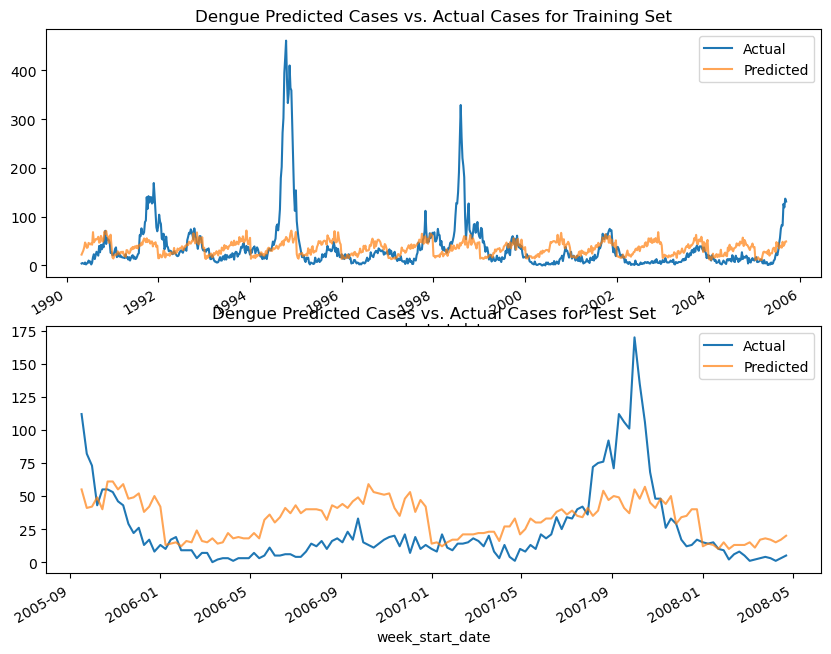

In [31]:
# Add predictions for the training set to the DataFrame for plotting
sj_train_subtrain['fitted'] = sj_model.fittedvalues

# Add predictions for the test set to the DataFrame
sj_train_subtest['fitted'] = sj_predictions

# Combine train and test predictions
combined_fitted = pd.concat([sj_train_subtrain['fitted'], sj_train_subtest['fitted']])

# Create the plot
figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot actual vs predicted for the training set
sj_train_subtrain.total_cases.plot(ax=axes[0], label="Actual")
sj_train_subtrain.fitted.plot(ax=axes[0], label="Predicted", alpha=0.7)
axes[0].set_title('Dengue Predicted Cases vs. Actual Cases for Training Set')

# Plot actual vs predicted for the test set
sj_train_subtest.total_cases.plot(ax=axes[1], label="Actual")
sj_train_subtest.fitted.plot(ax=axes[1], label="Predicted", alpha=0.7)
axes[1].set_title('Dengue Predicted Cases vs. Actual Cases for Test Set')

# Add legends and show plot
axes[0].legend()
axes[1].legend()
plt.show();

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Provided MAE calculations
sj_test_mae = round(mean_absolute_error(y_test_sj, sj_predictions), 2)
sj_train_mae = round(mean_absolute_error(y_train_sj, sj_model.fittedvalues), 2)

# Calculate Mean Squared Error (MSE) for test and train sets
sj_test_mse = round(mean_squared_error(y_test_sj, sj_predictions), 2)
sj_train_mse = round(mean_squared_error(y_train_sj, sj_model.fittedvalues), 2)

# Calculate the mean of actual values for test and train sets
mean_actual_test = y_test_sj.mean()
mean_actual_train = y_train_sj.mean()

# Calculate Relative Error for test and train sets (as a percentage)
sj_test_relative_error = round((sj_test_mae / mean_actual_test) * 100)
sj_train_relative_error = round((sj_train_mae / mean_actual_train) * 100)

# Output the results
(sj_test_mae, sj_train_mae, sj_test_mse, sj_train_mse, sj_test_relative_error, sj_train_relative_error)

(20.32, 27.58, 702.52, 2616.45, 84, 77)

In [33]:
sj_train_pred = sj_train
sj_train_pred['predicted_cases'] = sj_model.fittedvalues

# Look at the input features around the time of the peak
sj_1992_1993 = sj_train_pred.loc['1992':'1993']
sj_1992_1993.head()

# The strong rainfall on the 20.5.92 has caused the high peak

,weekofyear,precipitation_amt_mm,reanalysis_specific_humidity_g_per_kg,station_max_temp_c,station_min_temp_c,total_cases,ndvi,predicted_cases
week_start_date,,,,,,,,
1992-01-01,1,0.00,13.635714,28.3,19.4,81,0.162404,14.742358
1992-01-08,2,200.85,15.878571,30.6,20.6,104,0.106477,14.901933
1992-01-15,3,3.12,15.832857,31.1,21.7,90,0.212543,22.277702
1992-01-22,4,0.00,14.482857,30.6,20.0,85,0.152824,20.102839
1992-01-29,5,0.00,14.185714,28.9,20.0,55,0.137967,16.555629


## The Negativ Binomial Model - Iquitos

In [34]:
alpha_starting_value = 1.0

# Fit Negative Binomial model
iq_model = sm.GLM(y_train_iq, X_train_iq, family=sm.families.NegativeBinomial(alpha=alpha_starting_value)).fit()

# Get model summary
print(iq_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_cases   No. Observations:                  400
Model:                            GLM   Df Residuals:                      394
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1189.8
Date:                Wed, 14 Feb 2024   Deviance:                       572.51
Time:                        10:22:59   Pearson chi2:                     631.
No. Iterations:                    13   Pseudo R-squ. (CS):             0.1385
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [35]:
X_test_iq = iq_train_subtest.copy()
y_test_iq = X_test_iq.pop('total_cases')

iq_predictions = iq_model.predict(X_test_iq).astype(int)
iq_predictions

week_start_date
2008-03-11     9
2008-03-18     9
2008-03-25    11
2008-04-01     9
2008-04-08     8
              ..
2010-05-28     8
2010-06-04     8
2010-06-11     6
2010-06-18     8
2010-06-25     8
Length: 120, dtype: int64

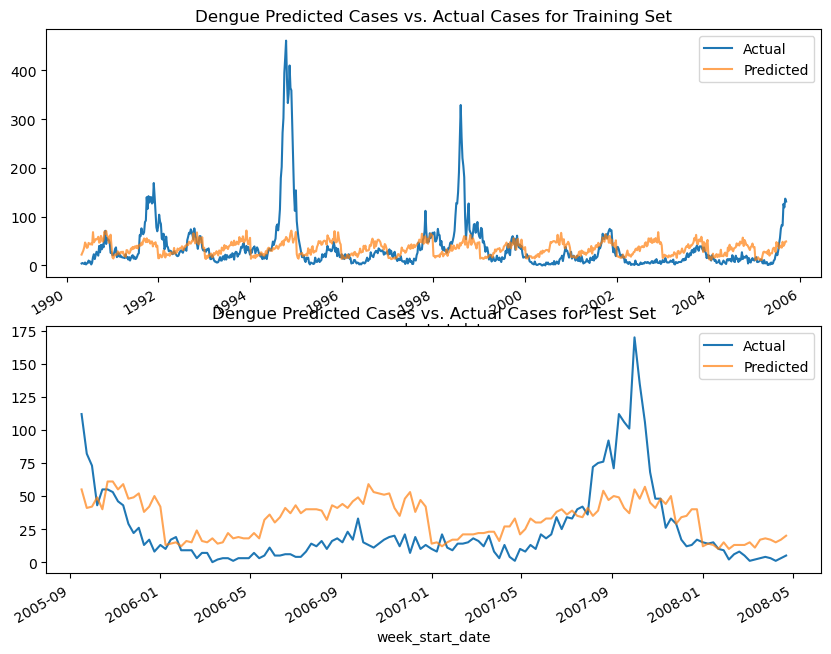

In [36]:
# Add predictions for the training set to the DataFrame for plotting
sj_train_subtrain['fitted'] = sj_model.fittedvalues

# Add predictions for the test set to the DataFrame
sj_train_subtest['fitted'] = sj_predictions

# Combine train and test predictions
combined_fitted = pd.concat([sj_train_subtrain['fitted'], sj_train_subtest['fitted']])

# Create the plot
figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot actual vs predicted for the training set
sj_train_subtrain.total_cases.plot(ax=axes[0], label="Actual")
sj_train_subtrain.fitted.plot(ax=axes[0], label="Predicted", alpha=0.7)
axes[0].set_title('Dengue Predicted Cases vs. Actual Cases for Training Set')

# Plot actual vs predicted for the test set
sj_train_subtest.total_cases.plot(ax=axes[1], label="Actual")
sj_train_subtest.fitted.plot(ax=axes[1], label="Predicted", alpha=0.7)
axes[1].set_title('Dengue Predicted Cases vs. Actual Cases for Test Set')

# Add legends and show plot
axes[0].legend()
axes[1].legend()
plt.show()

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Provided MAE calculations for iq
iq_test_mae = round(mean_absolute_error(y_test_iq, iq_predictions), 2)
iq_train_mae = round(mean_absolute_error(y_train_iq, iq_model.fittedvalues), 2)

# Calculate Mean Squared Error (MSE) for test and train sets for iq
iq_test_mse = round(mean_squared_error(y_test_iq, iq_predictions), 2)
iq_train_mse = round(mean_squared_error(y_train_iq, iq_model.fittedvalues), 2)

# Calculate the mean of actual values for test and train sets for iq
mean_actual_test_iq = y_test_iq.mean()
mean_actual_train_iq = y_train_iq.mean()

# Calculate Relative Error for test and train sets for iq (as a percentage)
iq_test_relative_error = round((iq_test_mae / mean_actual_test_iq) * 100)
iq_train_relative_error = round((iq_train_mae / mean_actual_train_iq) * 100)

# Output the results for iq
(iq_test_mae, iq_train_mae, iq_test_mse, iq_train_mse, iq_test_relative_error, iq_train_relative_error)

(6.93, 6.15, 129.88, 106.4, 81, 85)

## Generating a Submission file

In [38]:
sj_test, iq_test = preprocess_data('dengue_features_test.csv')

sj_predictions_test = sj_model.predict(sj_test).astype(int)
iq_predictions_test = iq_model.predict(iq_test).astype(int)

submission = pd.read_csv("submission_format.csv",index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions_test, iq_predictions_test])
submission.to_csv("negative_binomial_weeks_temp.csv")

With our baseline model we reached a MAE of 26.24 ranking within the top 50%